In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import jit

In [3]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [4]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [6]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [7]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [8]:
stdampall_ad = np.load('../features/stdampall_ad.npy')
stdampq2_ad = np.load('../features/stdampq2_ad.npy')
stdampq3_ad = np.load('../features/stdampq3_ad.npy')
stdampq4_ad = np.load('../features/stdampq4_ad.npy')

meanampall_ad = np.load('../features/meanampall_ad.npy')
meanampq2_ad = np.load('../features/meanampq2_ad.npy')
meanampq3_ad = np.load('../features/meanampq3_ad.npy')
meanampq4_ad = np.load('../features/meanampq4_ad.npy')

meanamppos = np.load('../features/meanamppos.npy')
meanampneg = np.load('../features/meanampneg.npy')


In [9]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg})

In [10]:
train = pd.concat([meta_train, train_features], axis=1)

In [11]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428,44.891664,0.670594,85.296720,24.976989,4.062346,0.000151,14.999402,1.249880,11.181670,-10.294509
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461,30.568193,35.273220,43.143698,24.977523,1.875258,2.500917,3.750465,1.249668,8.331531,-8.799846
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683,30.570660,43.144629,35.274377,24.978110,1.875325,3.750685,2.500106,1.250578,9.514662,-10.973763
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391,87.000132,60.780813,70.004487,43.144785,15.624495,7.500015,9.998660,3.750652,8.910585,-6.666027
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139,84.430994,60.780715,65.567084,24.979410,14.686710,7.499892,8.748330,1.249292,3.898276,-3.984866


In [12]:
id_target = train.groupby('id_measurement', as_index=False)['target'].sum()

target1_index = id_target[id_target['target']==1].index

target2_index = id_target[id_target['target']==2].index

In [13]:
for idx in target1_index:
    train.loc[train['id_measurement'] == idx, 'target'] = 0
        
for idx in target2_index:
    train.loc[train['id_measurement'] == idx, 'target'] = 1

In [14]:
train['target'].value_counts()

0    8187
1     525
Name: target, dtype: int64

In [15]:
signal_id = train['signal_id'].values
del train['signal_id']

In [16]:
target = train['target'].values
del train['target']

In [17]:
from sklearn.metrics import matthews_corrcoef

In [18]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)

[1]	valid_0's MCC: 0.57481
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.598982
[3]	valid_0's MCC: 0.610618
[4]	valid_0's MCC: 0.612933
[5]	valid_0's MCC: 0.613041
[6]	valid_0's MCC: 0.613894
[7]	valid_0's MCC: 0.60784
[8]	valid_0's MCC: 0.614423
[9]	valid_0's MCC: 0.618892
[10]	valid_0's MCC: 0.621157
[11]	valid_0's MCC: 0.626637
[12]	valid_0's MCC: 0.644429
[13]	valid_0's MCC: 0.639127
[14]	valid_0's MCC: 0.638837
[15]	valid_0's MCC: 0.643477
[16]	valid_0's MCC: 0.642514
[17]	valid_0's MCC: 0.64722
[18]	valid_0's MCC: 0.643924
[19]	valid_0's MCC: 0.646234
[20]	valid_0's MCC: 0.650597
[21]	valid_0's MCC: 0.65724
[22]	valid_0's MCC: 0.648989
[23]	valid_0's MCC: 0.644429
[24]	valid_0's MCC: 0.647514
[25]	valid_0's MCC: 0.647514
[26]	valid_0's MCC: 0.644121
[27]	valid_0's MCC: 0.645828
[28]	valid_0's MCC: 0.64309
[29]	valid_0's MCC: 0.644429
[30]	valid_0's MCC: 0.642179
[31]	valid_0's MCC: 0.636601
[32]	valid_0's MCC: 0.641548
[33]	valid_0's MCC: 0.64

[104]	valid_0's MCC: 0.617356
[105]	valid_0's MCC: 0.621419
[106]	valid_0's MCC: 0.621419
[107]	valid_0's MCC: 0.621419
[108]	valid_0's MCC: 0.623475
[109]	valid_0's MCC: 0.623475
[110]	valid_0's MCC: 0.621419
[111]	valid_0's MCC: 0.624424
[112]	valid_0's MCC: 0.626465
[113]	valid_0's MCC: 0.622566
[114]	valid_0's MCC: 0.619379
[115]	valid_0's MCC: 0.621419
[116]	valid_0's MCC: 0.622399
[117]	valid_0's MCC: 0.623475
[118]	valid_0's MCC: 0.623839
[119]	valid_0's MCC: 0.626465
[120]	valid_0's MCC: 0.624424
[121]	valid_0's MCC: 0.624424
[122]	valid_0's MCC: 0.62039
[123]	valid_0's MCC: 0.617356
[124]	valid_0's MCC: 0.621419
[125]	valid_0's MCC: 0.621419
[126]	valid_0's MCC: 0.626465
[127]	valid_0's MCC: 0.626465
[128]	valid_0's MCC: 0.626465
[129]	valid_0's MCC: 0.619379
[130]	valid_0's MCC: 0.61642
[131]	valid_0's MCC: 0.614864
[132]	valid_0's MCC: 0.61535
[133]	valid_0's MCC: 0.615734
[134]	valid_0's MCC: 0.617356
[135]	valid_0's MCC: 0.62039
[136]	valid_0's MCC: 0.625411
[137]	valid_0'

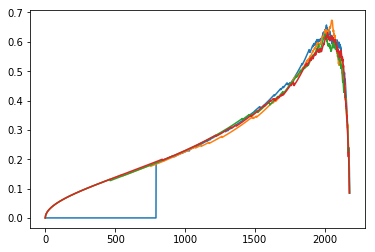

In [19]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in skf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [20]:
proba

[0.21586415730105254,
 0.26458861837773257,
 0.17604973588629982,
 0.16955490641308]

In [21]:
val_mcc

[0.6572397806056738,
 0.6734857146884927,
 0.6264647941005559,
 0.6313517640556888]

In [22]:
np.mean(val_mcc)

0.6471355133626028

0.6323985352015102 0.6323985352015102


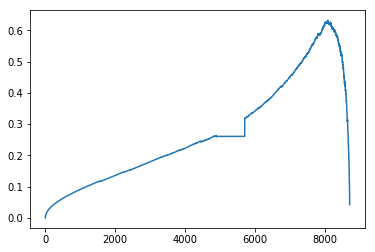

In [23]:
best_proba, best_mcc, y_pred = eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(best_proba)).astype(int))

array([[7938,  249],
       [ 150,  375]])

In [25]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks,3186.391258
MeanAmpAll_AD,1871.436194
MeanAmpNeg,638.996951
NumPeaks,578.873823
MeanAmpPos,574.127947
MinAmp,555.819261
StdAmpAll_AD,405.731683
NumPosPeaks,397.873567
StdAmpQ2,384.244408
id_measurement,352.819343


In [26]:
best_proba

0.20929937869657003

In [28]:
numpeaks = np.load('../features/numpeaks_test.npy')
numpospeaks = np.load('../features/numpospeaks_test.npy')
numnegpeaks = np.load('../features/numnegpeaks_test.npy')

maxpeakwidth = np.load('../features/maxpeakwidth_test.npy')
minpeakwidth = np.load('../features/minpeakwidth_test.npy')
meanpeakwidth = np.load('../features/meanpeakwidth_test.npy')
maxamp = np.load('../features/maxamp_test.npy')
minamp = np.load('../features/minamp_test.npy')
meanamp = np.load('../features/meanamp_test.npy')

stdampall = np.load('../features/stdampall_test.npy')
stdposall = np.load('../features/stdposall_test.npy')
stdwidthall = np.load('../features/stdwidthall_test.npy')

stdampq2 = np.load('../features/stdampq2_test.npy')
stdposq2 = np.load('../features/stdposq2_test.npy')
stdwidthq2 = np.load('../features/stdwidthq2_test.npy')
stdampq3 = np.load('../features/stdampq3_test.npy')
stdposq3 = np.load('../features/stdposq3_test.npy')
stdwidthq3 = np.load('../features/stdwidthq3_test.npy')
stdampq4 = np.load('../features/stdampq4_test.npy')
stdposq4 = np.load('../features/stdposq4_test.npy')
stdwidthq4 = np.load('../features/stdwidthq4_test.npy')


stdampall_ad = np.load('../features/stdampall_ad_test.npy')
stdampq2_ad = np.load('../features/stdampq2_ad_test.npy')
stdampq3_ad = np.load('../features/stdampq3_ad_test.npy')
stdampq4_ad = np.load('../features/stdampq4_ad_test.npy')

meanampall_ad = np.load('../features/meanampall_ad_test.npy')
meanampq2_ad = np.load('../features/meanampq2_ad_test.npy')
meanampq3_ad = np.load('../features/meanampq3_ad_test.npy')
meanampq4_ad = np.load('../features/meanampq4_ad_test.npy')

meanamppos = np.load('../features/meanamppos_test.npy')
meanampneg = np.load('../features/meanampneg_test.npy')


test_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg})

test = pd.concat([meta_test, test_features], axis=1)

test_id = test['signal_id'].values
del test['signal_id']

preds = None
for model in clf:
    if preds is None:
        preds = model.predict(test)
    else:
        preds += model.predict(test)
    
preds = preds/4

submission = pd.DataFrame({'signal_id':test_id,'target':(preds>best_proba).astype(int)})


In [ ]:
submission.to_csv('../output/submission_6.csv', index=False)